# Práctica 4a: selección de características numéricas


In [20]:
from sklearn.datasets import load_wine
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [21]:
x = load_wine()
df = pd.DataFrame(x.data, columns = x.feature_names)
df["MEDV"] = x.target
X = df.drop("MEDV",1)   #Características
y = df["MEDV"]          #Target
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,MEDV
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


# Filter Method

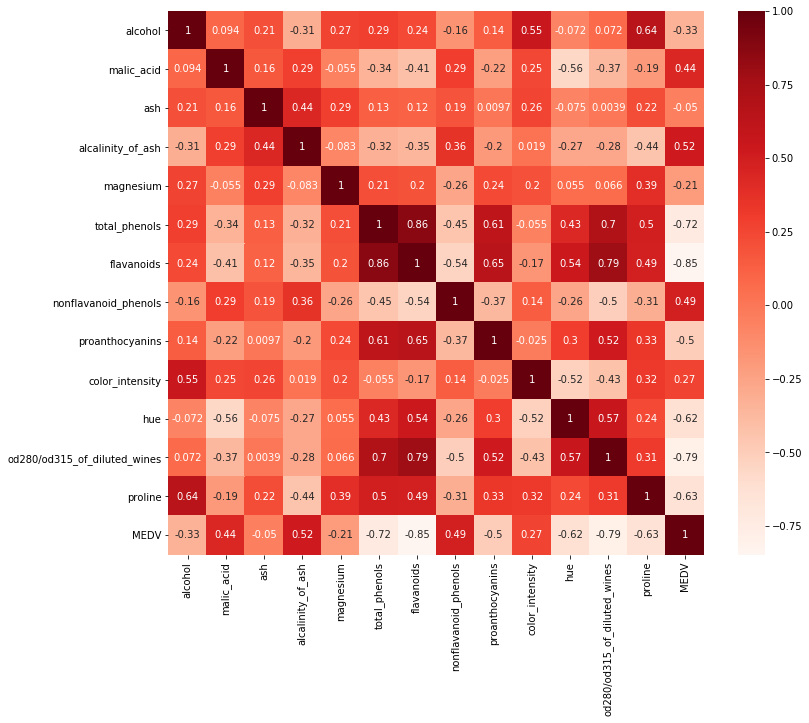

In [22]:
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [23]:
cor_target = abs(cor["MEDV"])

#Selección de características altamente correlacionadas
relevant_features = cor_target[cor_target>0.5]
relevant_features

alcalinity_of_ash               0.517859
total_phenols                   0.719163
flavanoids                      0.847498
hue                             0.617369
od280/od315_of_diluted_wines    0.788230
proline                         0.633717
MEDV                            1.000000
Name: MEDV, dtype: float64

In [26]:
print(df[["flavanoids","total_phenols"]].corr())
print(df[["alcalinity_of_ash","hue"]].corr())
print(df[["od280/od315_of_diluted_wines","flavanoids"]].corr())
print(df[["proline","hue"]].corr())

               flavanoids  total_phenols
flavanoids       1.000000       0.864564
total_phenols    0.864564       1.000000
                   alcalinity_of_ash       hue
alcalinity_of_ash           1.000000 -0.273955
hue                        -0.273955  1.000000
                              od280/od315_of_diluted_wines  flavanoids
od280/od315_of_diluted_wines                      1.000000    0.787194
flavanoids                                        0.787194    1.000000
          proline       hue
proline  1.000000  0.236183
hue      0.236183  1.000000


# Wrapper Method

### Backward Elimination

In [27]:
#Agregar una columna constante de unos, obligatorio para el modelo sm.OLS
X_1 = sm.add_constant(X)

#Ajuste del modelo sm.OLS
model = sm.OLS(y,X_1).fit()
model.pvalues.sort_values(ascending=False)

magnesium                       7.591622e-01
proanthocyanins                 4.033841e-01
hue                             2.658810e-01
malic_acid                      1.728962e-01
ash                             1.514595e-01
nonflavanoid_phenols            1.426491e-01
total_phenols                   2.464123e-02
alcohol                         1.845335e-03
alcalinity_of_ash               6.793864e-06
od280/od315_of_diluted_wines    7.339233e-07
color_intensity                 4.279710e-07
proline                         1.279426e-10
const                           6.960263e-11
flavanoids                      9.736855e-12
dtype: float64

In [28]:
cols = list(X.columns)
pmax = 1

while (len(cols)>0):
    p = []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax > 0.05):
        cols.remove(feature_with_p_max)
    else:
        break
        
selected_features_BE = cols
print(selected_features_BE)

['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'total_phenols', 'flavanoids', 'color_intensity', 'od280/od315_of_diluted_wines', 'proline']


#### Recursive Feature Elimination (RFE)

In [31]:
model = LinearRegression()

#Método RFE
rfe = RFE(model, 7, verbose=1)

#Transformando los datos usando el método RFE
X_rfe = rfe.fit_transform(X,y)  

#Encontrando el modelo de los datos
model.fit(X_rfe,y)
print(rfe.support_)
print(rfe.ranking_)

Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
[ True False  True False False  True  True  True False False  True  True
 False]
[1 4 1 2 7 1 1 1 5 3 1 1 6]


In [32]:
#Número de características
nof_list = np.arange(1,13)            
high_score = 0

#Proceso para almacenar las características óptimas
nof = 0           
score_list = []

for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
        
print("Número óptimo de características: %d" %nof)
print("Desempeño con %d características: %f" % (nof, high_score))

Número óptimo de características: 12
Desempeño con 12 características: 0.843879


In [33]:
cols = list(X.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 10)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index=cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'total_phenols',
       'flavanoids', 'nonflavanoid_phenols', 'color_intensity', 'hue',
       'od280/od315_of_diluted_wines'],
      dtype='object')


## Embedded Method

In [34]:
reg = LassoCV()
reg.fit(X, y)
coef = pd.Series(reg.coef_, index = X.columns)
print("Número óptimo de características:" + str(sum(coef != 0)))
print("Desempeño mediante la regularización Lasso: %f" %reg.score(X,y))

Número óptimo de características:4
Desempeño mediante la regularización Lasso: 0.814756


Text(0.5, 1.0, 'Importancia de las características usando el modelo de Lasso')

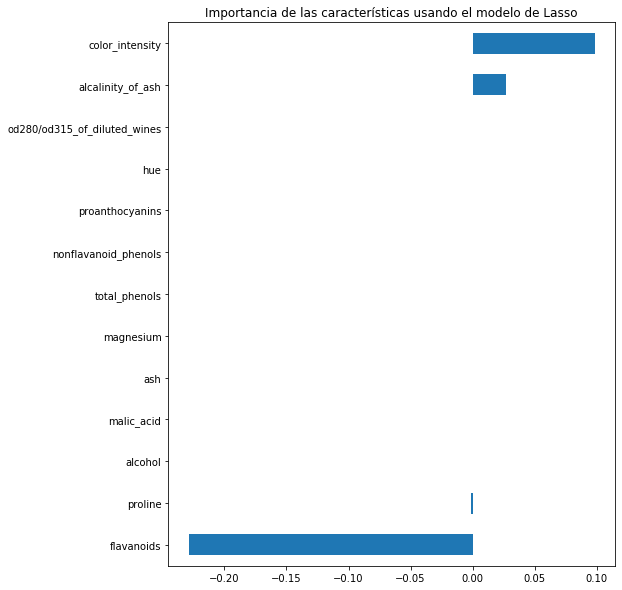

In [35]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Importancia de las características usando el modelo de Lasso")